### Seq2VAR: multivariate time series representation with relational neural networks and linear autoregressive model

##### Edouard Pineau, Sébastien Razakarivony, Thomas Bonald


### ===========================================================================================

## Setup

The appendices 'data_generator_permutations.py', 'argument_parser_permutations.py', 'utils.py' and 'modules.py' contain the required supplementary python code for running this notebook. 

In [1]:
import copy
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import time

from utils import *
from modules import *
from data_generator_permutations import *
from argument_parser_permutations import *

from itertools import permutations
from statsmodels.tsa.vector_ar.var_model import VAR

In [2]:
args = argument_parser()
print(args)

Namespace(batch_size=128, cuda=True, in_dim=1, lag=1, nb_samples_per_system=100, nb_systems=10, num_atoms=10, sd=0, timesteps=25)


### Sample data with additive observation noise

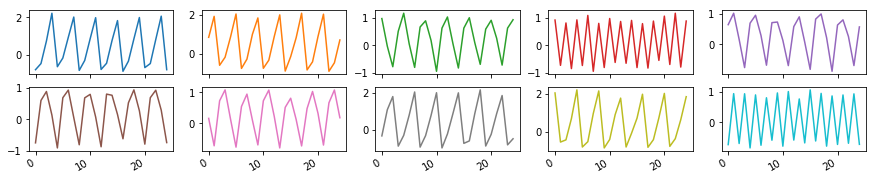

In [3]:
### Standard deviation of the additive noise over the observations
args.sd = 0.1

v, ml, l = generate_permutation_ts(args.num_atoms, args.timesteps, 1, 1, sd=args.sd)
pd.DataFrame(v[0, :, :, 0].T).plot(subplots=True, layout=(4, 5), figsize=(15, 6), legend=False);

In [4]:
X_train, A_train, labels_train = generate_permutation_ts(args.num_atoms, 
                                                         args.timesteps, 
                                                         args.nb_systems, 
                                                         args.nb_samples_per_system, 
                                                         args.sd)
X_test, A_test, labels_test = generate_permutation_ts(args.num_atoms, 
                                                      args.timesteps, 
                                                      args.nb_systems, 
                                                      args.nb_samples_per_system, 
                                                      args.sd)

In [5]:
X_train = torch.FloatTensor(X_train)
labels_train = torch.FloatTensor(labels_train)
X_test = torch.FloatTensor(X_test)
labels_test = torch.FloatTensor(labels_test)

train_data = TensorDataset(X_train, labels_train)
train_data_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)

test_data = TensorDataset(X_test, labels_test)
test_data_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False)

# Training the different models

### Matrix estimation with standard VAR

VAR has no inference mechanism shared by any number of samples. It is one VAR for one sample. Each new sample requires the fitting of a VAR for representation learning. 

Therefore, no training is required here, we learn at test time.

### Seq2VAR: relational encoder with linear decoder for MTS representation learning

In [6]:
args_seq2var = argument_parser_seq2var()
print(args_seq2var)

Namespace(encoder_hidden=64, epochs=2000, lr=0.001, prior=0.1, tau=0.1)


In [7]:
encoder_seq2var = RelationalEncoder(args.timesteps, args_seq2var.encoder_hidden, args.lag)

if args.cuda:
    encoder_seq2var = encoder_seq2var.cuda()

optimizer_encoder = optim.Adam(encoder_seq2var.parameters(), lr=args_seq2var.lr)
scheduler = optim.lr_scheduler.StepLR(optimizer_encoder, step_size=250, gamma=0.5)

/home/epineau/anaconda3/envs/edouard/lib/python3.6/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU0 Quadro K4000 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [ ]:
train_seq2var(train_data_loader, encoder_seq2var, optimizer_encoder, scheduler, args, args_seq2var, binary=False)

### Binary Seq2VAR

off_diag = np.ones([args.num_atoms, args.num_atoms])

rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
rel_rec = torch.FloatTensor(rel_rec)
rel_send = torch.FloatTensor(rel_send)

In [9]:
encoder_bseq2var = RelationalEncoder(args.timesteps, args_seq2var.encoder_hidden, args.lag)

if args.cuda:
    encoder_bseq2var = encoder_bseq2var.cuda()

optimizer_encoder = optim.Adam(encoder_bseq2var.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer_encoder, step_size=250, gamma=0.5)

In [ ]:
train_seq2var(train_data_loader, encoder_bseq2var, optimizer_encoder, scheduler, args, args_seq2var, binary=True)

## NRI

In [11]:
args_nri = argument_parser_nri()
print(args_nri)

Namespace(cuda=True, decoder='mlp', decoder_dropout=0.0, decoder_hidden=64, dynamic_graph=False, edge_types=2, encoder='mlp', encoder_dropout=0.0, encoder_hidden=64, epochs=2000, factor=True, gamma=0.5, hard=False, in_dim=1, lr=0.0005, lr_decay=200, no_factor=False, num_atoms=10, prediction_steps=1, prior=True, seed=42, skip_first=False, stationary=True, suffix='_springs10', temp=0.5, var=5e-05)
Namespace(cuda=True, decoder='mlp', decoder_dropout=0.0, decoder_hidden=64, dynamic_graph=False, edge_types=2, encoder='mlp', encoder_dropout=0.0, encoder_hidden=64, epochs=2000, factor=True, gamma=0.5, hard=False, in_dim=1, lr=0.0005, lr_decay=200, no_factor=False, num_atoms=10, prediction_steps=1, prior=True, seed=42, skip_first=False, stationary=True, suffix='_springs10', temp=0.5, var=5e-05)


In [12]:
if args_nri.prior:
    prior = np.array([0.9, 0.1])
    log_prior = torch.FloatTensor(np.log(prior))
    log_prior = torch.unsqueeze(log_prior, 0)
    args_nri.log_prior = torch.unsqueeze(log_prior, 0)
    
    if args.cuda:
        args_nri.log_prior = args_nri.log_prior.cuda()

In [13]:
nri_encoder = RelationalEncoder(args.timesteps, 
                                 args_nri.encoder_hidden, 
                                 args_nri.edge_types, 
                                 args_nri.encoder_dropout, 
                                 args_nri.factor)
nri_decoder = RelationalDecoder(n_in_node=args_nri.in_dim, 
                                 edge_types=args_nri.edge_types, 
                                 msg_hid=args_nri.decoder_hidden,
                                 msg_out=args_nri.decoder_hidden, 
                                 n_hid=args_nri.decoder_hidden, 
                                 do_prob=args_nri.decoder_dropout,
                                 skip_first=args_nri.skip_first)

if args.cuda:
    nri_encoder.cuda()
    nri_decoder.cuda()
    
optimizer = optim.Adam(list(nri_encoder.parameters()) + list(nri_decoder.parameters()), lr=args_nri.lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args_nri.lr_decay, gamma=args_nri.gamma)

Using learned interaction net decoder.


In [ ]:
train_nri(train_data_loader, nri_encoder, nri_decoder, optimizer, scheduler, args, args_nri)

best_val_loss = np.inf
best_epoch = 0
for epoch in range(args.epochs):
    train(epoch, train_data_loader, nri_encoder, nri_decoder, rel_rec_nri, rel_send_nri, optimizer, scheduler, args, args_nri)

## Performances

### Classification and causality discovery of the different models

In [15]:
l_test, A_vars, A_seq2vars, A_bseq2vars, A_nris, A_GT = [], [], [], [], [], []
encoder_seq2var.eval()
encoder_bseq2var.eval()
nri_encoder.eval()
nri_decoder.eval()

for data, label in test_data_loader:
    
    l_test.append(label)
    X = data
    
    # VAR
    for d in data:
        model = VAR(d.squeeze().numpy().T)
        results = model.fit(1, trend='c')
        A_vars.append(results.coefs)
    
    # seq2VAR
    off_diag = np.ones([args.num_atoms, args.num_atoms])
    rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
    rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
    rel_rec = torch.FloatTensor(rel_rec)
    rel_send = torch.FloatTensor(rel_send)
    
    A_seq2var = encoder_seq2var.cpu()(X, rel_rec, rel_send)
    A_seq2vars.append(A_seq2var.contiguous().view(-1, args.num_atoms, args.num_atoms).cpu().detach())
    
    # binary seq2VAR
    A_bseq2VAR = encoder_bseq2var.cpu()(X, rel_rec, rel_send)
    A_bseq2VAR = (A_bseq2VAR > 0).float()
    A_bseq2vars.append(A_bseq2VAR.contiguous().view(-1, args.num_atoms, args.num_atoms).cpu().detach())
    
    # NRI
    off_diag = np.ones([args.num_atoms, args.num_atoms]) - np.eye(args.num_atoms)

    rel_rec_nri = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
    rel_send_nri = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
    rel_rec_nri = torch.FloatTensor(rel_rec_nri)
    rel_send_nri = torch.FloatTensor(rel_send_nri)
    
    logits = F.softmax(nri_encoder.cpu()(X, rel_rec_nri, rel_send_nri), 2)
    edges = (logits < 0.5).float()
    A_nri = torch.zeros(X.size(0), args.num_atoms, args.num_atoms).float()
    for j in range(args.num_atoms):
        A_nri[:, j, [k for k in range(args.num_atoms) if k != j]] = edges[:, j*(args.num_atoms-1):(j+1)*(args.num_atoms-1), torch.argmin(edges.mean(1).mean(0)).item()].cpu()
    A_nris.append(A_nri.cpu().detach())
    
    A_GT.append(np.stack([A_test[l.item()] for l in label]))
    

A_vars_binarized = torch.FloatTensor(np.concatenate([(np.abs(w) > np.percentile(np.abs(w), q=90)) for w in A_vars]).astype(float))
A_vars = torch.FloatTensor(np.concatenate(A_vars))
A_seq2vars = torch.cat(A_seq2vars)
A_seq2vars_binarized = torch.stack([(w.abs() > np.percentile(w.abs(), q=90)) for w in A_seq2vars]).float()
A_bseq2vars = torch.cat(A_bseq2vars)
A_nris = torch.transpose(torch.cat(A_nris), 1, 2)
A_GT = torch.FloatTensor(np.concatenate(A_GT))
l_test = torch.cat(l_test)

### Classification performance: accuracy

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [17]:
names = ['VAR\t\t', 'Seq2VAR\t\t', 'bSeq2VAR\t', 'NRI\t\t']
for A_est, name_method in zip([A_vars, A_seq2vars, A_bseq2vars, A_nris], names):
    X_train, X_test, y_train, y_test = train_test_split(A_est.reshape(A_est.shape[0], -1).numpy(), l_test.numpy())
    rf = KNeighborsClassifier(n_neighbors=1)
    rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    
    print(name_method, 'Accuracy:', np.mean(rf.predict(X_test.reshape(X_test.shape[0], -1))==y_test))

VAR		 Accuracy: 1.0
Seq2VAR		 Accuracy: 1.0
bSeq2VAR	 Accuracy: 1.0
NRI		 Accuracy: 0.992


### Causality detection performance: F1-score

In [18]:
names = ['VAR\t\t', 'Seq2VAR\t\t', 'bSeq2VAR\t', 'NRI\t\t']
for A_est, name_method in zip([A_vars_binarized, A_seq2vars_binarized, A_bseq2vars, A_nris], names):
    A_GT = torch.FloatTensor(A_GT)
    A_est = A_est.float()
    tp = (A_GT*A_est).sum()
    fp = ((1-A_GT)*A_est).sum()
    fn = (A_GT*(1-A_est)).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    F_score = 2*precision*recall/(precision+recall)
    print(name_method, 'precision:', "%.2f" % precision.item(), '\trecall:', "%.2f" % recall.item(), '\tF1_score:', "%.2f" % F_score.item())

VAR		 precision: 0.69 	recall: 0.69 	F1_score: 0.69
Seq2VAR		 precision: 0.99 	recall: 0.99 	F1_score: 0.99
bSeq2VAR	 precision: 0.95 	recall: 0.93 	F1_score: 0.94
NRI		 precision: 0.62 	recall: 0.99 	F1_score: 0.76


## Further analysis

In [19]:
distances = np.array([[torch.norm(A_gt - A_est[i], 1) for i,A_gt in enumerate(A_GT)] for A_est in [A_vars_binarized, A_nris, A_seq2vars_binarized, A_bseq2vars]])

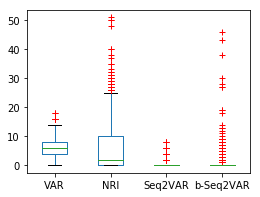

In [20]:
pd.DataFrame(distances.T, columns=['VAR', 'NRI', 'Seq2VAR', 'b-Seq2VAR']).plot.box(sym='r+', figsize=(4, 3))

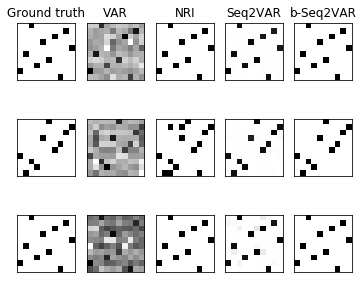

In [21]:
fig, axes = plt.subplots(3, 5, figsize=(6, 5))
for ax in axes.flat:
    ax.set(xticks=[], yticks=[])
    
    
for i in range(3):
    j = np.random.randint(len(test_data_loader.dataset))
    
    # all plots
    
    axes[i, 0].imshow(A_GT[j], cmap='binary', label='ground truth')
    axes[i, 1].imshow(A_vars[j], cmap='binary', label='VAR')
    axes[i, 2].imshow(A_nris[j], cmap='binary')
    axes[i, 3].imshow(A_seq2vars[j].numpy(), cmap='binary', label='seq2VAR')
    axes[i, 4].imshow(A_bseq2vars[j].numpy(), cmap='binary', label='binary seq2VAR')
    
    
for ax, name in zip(axes[0], ['Ground truth', 'VAR', 'NRI', 'Seq2VAR', 'b-Seq2VAR']):
    ax.set_title(name)
plt.show(block=False)

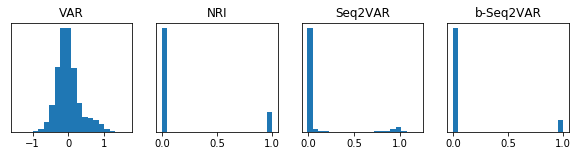

In [22]:
fig, axes = plt.subplots(1, 4, figsize=(10, 2))

for ax in axes.flat:
    ax.set(yticks=[])

axes[0].hist(A_vars.flatten(), bins=20);
axes[1].hist(A_nris.flatten(), bins=20);
axes[2].hist(A_seq2vars.flatten(), bins=20);
axes[3].hist(A_bseq2vars.flatten(), bins=20);

for ax, name in zip(axes, ['VAR', 'NRI', 'Seq2VAR', 'b-Seq2VAR']):
    ax.set_title(name)